In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_utils import BasicFunctions, PriceFunctions
from TechnicalAnalysis import TechnicalAnalysis 
from BackTest import Backtester
import math
import tensorflow as tf
from scipy.stats import linregress

%matplotlib inline
%load_ext autoreload
%autoreload 2

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
from keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Activation, Dropout, BatchNormalization
from keras.models import Model

btc = quandl.get('BCHARTS/COINBASEUSD', start_date='2017/4/15', end_date='2017/5/15')
eth = quandl.get('GDAX/ETH_USD', start_date='2017/4/15', end_date='2017/5/15')

btc.to_csv('btc.csv')
eth.to_csv('eth.csv')

In [97]:
import numpy as np
import pandas as pd
from data_utils import BasicFunctions, PriceFunctions

class strategyBacktest():
    
    def __init__(self, bar, features='', conditions='', trainSize=0.8):
        '''
        Parameters:
        ___________
        
        bar: 
        Pandas Dataframe containing Date, Open, High, Low, Close and Volume
        
        features: 
        The Features to use to predict during this prediction. Data and other column of pandas features
        
        conditions: 
        Conditions to apply using the features
        
        '''
        self.bar = bar
        self.features = features
        self.conditions = conditions
        self.trainSize = trainSize
        
        self.y = pd.DataFrame(columns={'Percentage Change', 'Classification'})
        self.y['Percentage Change'] = (1 - self.bar['Close']/self.bar.shift(-1)['Close'])
        self.y['Classification'] = self.y['Percentage Change'] > 0
        self.y['Classification'] = self.y['Classification'] * 1
        
        self.y = self.y.fillna(method='ffill')
        
    def mlBacktest(self):
        
        if ('Date' in self.features):
            dates = self.features['Date']
            self.features = self.features.drop('Date', axis=1)
            
#         inp = Input(shape=(None, self.features.shape[1]))
        
#         x = LSTM(32)(inp)
#         x = BatchNormalization()(x)
#         x = Dropout(0.4)(x)
        
#         x = Dense(5, activation='elu')(x)
#         x = BatchNormalization()(x)
#         x = Dropout(0.4)(x)
        
#         x = Dense(2, activation='elu')(x)
#         x = BatchNormalization()(x)
#         x = Dropout(0.4)(x)
        
#         model = Model(inp, x)
        
#         #print(model.summary())
        
#         model.compile(optimizer='adam', loss='mean_squared_error')
        
#         X = np.asarray(self.features)
        Y = np.asarray(self.y)
        
#         model.fit(x=X.reshape(-1, 1, self.features.shape[1]), y=Y, batch_size=16, epochs=100)
        
#         ypred = model.predict(X.reshape(-1, 1, self.features.shape[1]))
        
        bars = {}
        signals = {}
        
        bars['BTC'] = self.bar
        signals['BTC'] = Y
        
        bt = Backtester(bars, signals, comission=0)
        bt.perform_backtest()
        
        positions = bt.get_positions()
        portfolioValue = bt.get_portfolioValue()
        
        print(positions)
        print(portfolioValue)
        
        bt.get_outcome() #perform great when y itself is used. Note this. Also now fix chart.

C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\backtester.py:197: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for coin in currprice:
C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\backtester.py:199: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


         Date Coin    Price      Bankroll        Amount   Type Position  \
0   4/16/2017  BTC  1177.99      0.000000  10000.000000   OPEN     LONG   
1   4/17/2017  BTC  1189.91      0.000000      0.000000   OPEN     LONG   
2   4/18/2017  BTC  1201.94      0.000000      0.000000   OPEN     LONG   
3   4/19/2017  BTC  1214.21      0.000000      0.000000   OPEN     LONG   
4   4/20/2017  BTC  1236.15      0.000000      0.000000   OPEN     LONG   
5   4/21/2017  BTC  1249.99  10611.210621  10000.000000  CLOSE    SHORT   
6   4/21/2017  BTC  1249.99  21222.210621  10611.000000   OPEN    SHORT   
7   4/22/2017  BTC  1247.00  10636.592337  10611.000000  CLOSE     LONG   
8   4/22/2017  BTC  1247.00      0.592337  10636.000000   OPEN     LONG   
9   4/23/2017  BTC  1251.98      0.592337      0.000000   OPEN     LONG   
10  4/24/2017  BTC  1257.29      0.592337      0.000000   OPEN     LONG   
11  4/25/2017  BTC  1281.16      0.592337      0.000000   OPEN     LONG   
12  4/26/2017  BTC  1298.

C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\calculations.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = (np.average(percentage)/drawDown)


Portfolio Stats:
Total Return: 82.1%
Sharpe Ratio: 17.279 Calmar Ratio: -inf Sortino Ratio: nan Maximum Drawdown: 0.0%

BTC Portfolio:
Total Return: 48.37%
Sharpe Ratio: 10.448 Calmar Ratio: -inf Sortino Ratio: 8.969 Maximum Drawdown: 0.0%


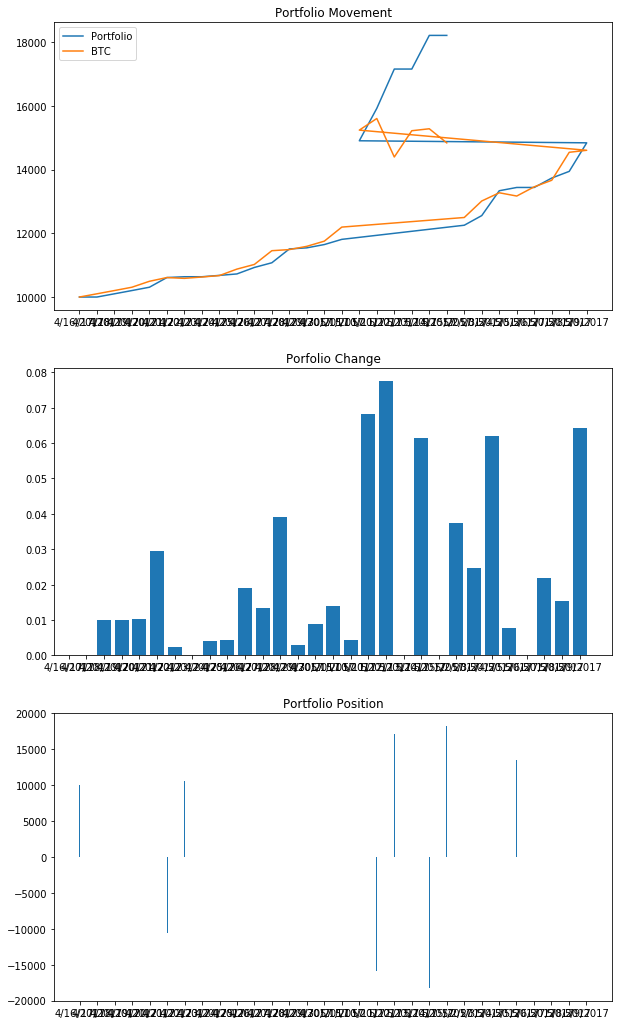

In [100]:
import numpy as np
import pandas as pd

class TeststrategyBacktest():
    def __init__(self):
        self.df = pd.read_csv('BackTest/tests/btc_test.csv')
        self.features = pd.DataFrame(columns=['Date', 'feature1', 'feature2'])
        self.features['Date'] = self.df['Date']
        self.features['feature1'] = self.df['Close']/sum(self.df['Close'])
        self.features['feature2'] = self.df['Open'] - np.mean(self.df['Open'])
    
    def test_mlBacktest(self):
        sb = strategyBacktest(self.df, self.features)
        sb.mlBacktest()
        
TeststrategyBacktest().test_mlBacktest()

In [ ]:
bf = BasicFunctions()
pf = PriceFunctions()

In [8]:
# df = pf.get_pandas(coin='BTC', targetdays=24, absolute=True) #as the data is hourly
# ta = TechnicalAnalysis(df, timeframe=[24], period=[14])
# ta.merge_time()

# df_withta = ta.get_dic()['24hour'] #for merging 24 into 1 for now

In [9]:
# ta = TechnicalAnalysis(df, timeframe=[3,6,12,24], period=[14, 20])
# ta.merge_time()

# ta.perform('obv')
# ta.perform('macd')
# ta.perform('bollingerband')
# ta.perform('volumechange')
# ta.perform('rsi')


# df_withta = ta.get_dataframe()

#test and train should be merged while doing this

In [10]:
pd_Xtrain, pd_ytrain, pd_Xtest, pd_ytest = pf.split_traintest(df_withta)
mean, std, Xtrain, ytrain, Xtest, ytest = pf.get_numpy(pd_Xtrain, pd_ytrain, pd_Xtest, pd_ytest)

In [11]:
def create_placeholders():
    X = tf.placeholder(tf.float32, shape=(None, 5), name='X')
    y = tf.placeholder(tf.float32, shape=(None, 2), name='y')
    
    return X,y

In [12]:
def forward_propagation(X, training):
    Z1 = tf.layers.dense(X, 30, name='Z1', kernel_initializer=tf.keras.initializers.he_normal(seed=1))
    bn1 = tf.layers.batch_normalization(Z1, training=training, name='bn1')
    ac1 = tf.nn.relu(bn1, name='ac1')
    A1 = tf.layers.dropout(ac1, 0.3, name='A1')
    
    Z2 = tf.layers.dense(A1, 15, name='Z2', kernel_initializer=tf.keras.initializers.he_normal(seed=1))
    bn2 = tf.layers.batch_normalization(Z2, training=training, name='bn2')
    ac2 = tf.nn.relu(bn2, name='ac2')
    A2 = tf.layers.dropout(ac2, 0.3, name='A2')
    
    Z3 = tf.layers.dense(A2, 2, name='Z3', kernel_initializer=tf.keras.initializers.he_normal(seed=1))
    #A3 = tf.nn.relu(Z3)

    return Z3

In [13]:
def cost_function(AL, y):
    classcost = tf.reduce_mean(tf.square(y[:, 0] - AL[:, 0]))
    percost = tf.reduce_mean(tf.square(y[:, 1] - AL[:, 1]))
    
    classification  = tf.abs(tf.log(classcost))
    regression = tf.abs(tf.log(percost))
    
    cost = 0.5 * classification + 5 * regression
    
    costs = [cost, classification, regression]
    
    return costs

In [14]:
import os
cwd = os.getcwd()

from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

Iteration: 0
Classification cost: 0.7455035448074341
Regression cost: 0.033775780349969864
Total Clost: 0.1457231342792511


Iteration: 50
Classification cost: 0.10798188298940659
Regression cost: 0.007657085545361042
Total Clost: 0.0208306685090065


Iteration: 100
Classification cost: 0.09215725213289261
Regression cost: 0.015237356536090374
Total Clost: 0.016907714307308197


Iteration: 150
Classification cost: 0.1760958582162857
Regression cost: 0.0031116423197090626
Total Clost: 0.03490800783038139


Iteration: 200
Classification cost: 0.13211695849895477
Regression cost: 0.01871434971690178
Total Clost: 0.024551957845687866


Iteration: 250
Classification cost: 0.04073284938931465
Regression cost: 0.012677083723247051
Total Clost: 0.00687886169180274


Iteration: 300
Classification cost: 0.20292463898658752
Regression cost: 0.0005989664932712913
Total Clost: 0.040525030344724655


Iteration: 350
Classification cost: 0.13048423826694489
Regression cost: 0.0065960390493273735
Total

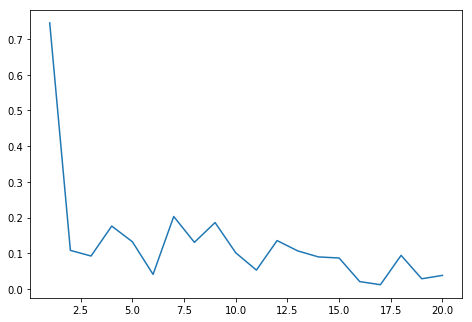

In [15]:
tf.reset_default_graph()

with tf.name_scope('Initialize'):
    X, y = create_placeholders()
    training = tf.placeholder(tf.bool, shape=(), name='training')
    
with tf.name_scope('ForwardPropagation'):
    AL = forward_propagation(X, training)
    
with tf.name_scope('CostFunction'):
    cost = cost_function(AL, ytrain)
    
with tf.name_scope('BackPropagation'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005).minimize(cost[0])
    
init = tf.global_variables_initializer()

cost_summary = tf.summary.scalar('Cost', cost[0])
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

costs = []

with tf.Session() as sess:
    sess.run(init)
    mini_batches = bf.initialize_mini_batch(Xtrain, ytrain, batchsize=32)
    
    for i in range(1000):
        for batch in mini_batches:
            (Xbatch, ybatch) = batch
            sess.run(optimizer, feed_dict={X: Xbatch, y: ybatch, training: True})
            
        if (i % 50 == 0):
            cost_str = cost_summary.eval(feed_dict={X: Xbatch, y: ybatch, training: True})
            
            cost0 = cost[0].eval(feed_dict={X: Xbatch, y: ybatch, training: True})
            cost1 = cost[1].eval(feed_dict={X: Xbatch, y: ybatch, training: True})
            cost2 = cost[2].eval(feed_dict={X: Xbatch, y: ybatch, training: True})
            
            costs.append(cost0)
            
            print("Iteration: {}\nClassification cost: {}\nRegression cost: {}\nTotal Clost: {}\n\n".format(i, cost0, cost1, cost2))
            
            file_writer.add_summary(cost_str, i)
            
    
    saver = tf.train.Saver()
    saver.save(sess, cwd + '/tf_logs/session/session.chkp')
    file_writer.close()
    
bf.single_plot(costs, log=False)

In [18]:
def sigmoid(Z):
    return (1/(1+np.exp(-Z)))

def calculate_accuracy(AL, y):
    #calculate accuracy, precision, recall and F1 value here too
    ALc = AL[:, 0]
    yc = y[:, 0]
    
    ALc = ALc > 0.5
    ALc = ALc.astype(int)
    
    total = ALc.shape[0]
    
    TP = np.sum(np.logical_and(ALc==1, yc==1))
    TN = np.sum(np.logical_and(ALc==0, yc==0))
    
    FP = np.sum(np.logical_and(ALc==1, yc==0))
    FN = np.sum(np.logical_and(ALc==0, yc==1))
    
    P = TP / (TP + FP)
    R = TP / (TP + TN)
    F1 = (2 * P * R) / (P + R)
    
    
    acc = np.sum(ALc == yc)/total
    
    
    print("\nAccuracy: {} \n".format(acc))
    print("True Positive: {} \nTrue Negative: {}\nFalse Positive: {} \nFalse Negative: {}\n".format(TP, TN, FP, FN))
    print("Precision: {} \nRecall: {} \nF1 Score: {}\n".format(P, R, F1))
    
    
    ALcr = AL[:, 1]
    ycr = y[:, 1]

    fig, axes = plt.subplots(figsize=(12,6))
    axes.plot(ALcr, label="Predicted Value")
    axes.plot(ycr, label="Actual Value")
    axes.set_ylabel("Percentage Change")
    axes.set_title("Regression Comparision")
    axes.legend(loc=4)
    
    slope, intercept, rval, pval, stderr = linregress(ycr, ALcr)
    print("R-Value: " + str(rval)) #rvalue is between -1 and 1 and can be used for single. Suitable for my purpose. R2 can be used for multiple, gives one and zero
    
    maximum = max(ycr.max(),AL.max())
    minimum = min(ycr.min(),ALcr.min())
    fig2, ax2 = plt.subplots(figsize=(12,6))
    ax2.scatter(ycr,ALcr)
    ax2.plot([minimum, maximum], [minimum, maximum], 'r-', lw=2)
    
    #plot this
    return AL, y

INFO:tensorflow:Restoring parameters from C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor/tf_logs/session/session.chkp

Accuracy: 0.5120320855614974 

True Positive: 513 
True Negative: 253
False Positive: 441 
False Negative: 289

Precision: 0.5377358490566038 
Recall: 0.6697127937336814 
F1 Score: 0.5965116279069766

R-Value: 0.05016602609857674


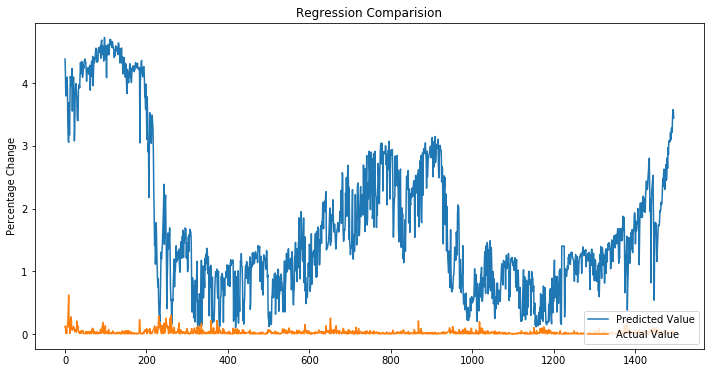

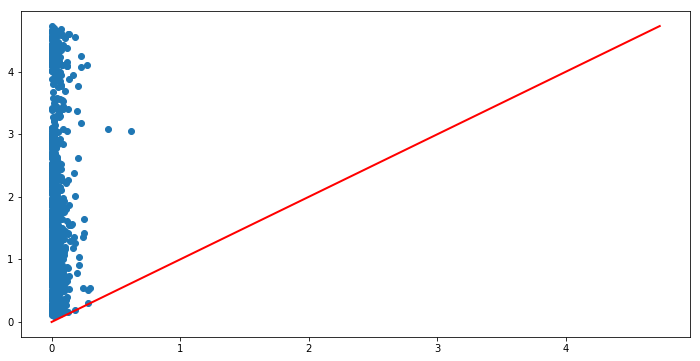

In [19]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, cwd + '/tf_logs/session/session.chkp')
    
    Z = sess.run(AL, feed_dict={X: Xtrain, training: False})
    Z[:, 0] = sigmoid(Z[:, 0])
    
    AL, y = calculate_accuracy(Z, ytrain)

In [27]:
combined = pd.concat([pd_Xtrain, pd_ytrain], axis=1)

In [34]:
bars = {}
bars['BTC'] = combined

signals = {}
signals['BTC'] = np.asarray(pd_ytrain)

bars['BTC']['Date'] = bars['BTC'].index

In [35]:
bt = Backtester(bars, signals, comission=0) #bars should contain 
bt.perform_backtest()
positions = bt.get_positions()
portfolioValue = bt.get_portfolioValue()

KeyError: 0

In [37]:
bars['BTC']

,Open,Close,High,Low,Volume,Classification,Percentage Change,Date
Time,,,,,,,,
1364774400,93.250000,103.999000,105.9000,92.49999,5535.487513,1,0.120362,1364774400
1364860800,104.000000,118.229354,118.3867,99.00000,8376.527478,1,0.122277,1364860800
1364947200,117.958261,134.700000,146.8800,101.51088,12996.245072,0,0.013552,1364947200
1365033600,134.716560,132.899000,143.0000,119.00000,6981.668305,1,0.066065,1365033600
1365120000,130.100010,142.300000,145.0000,128.25000,5234.882203,1,0.005243,1365120000
1365206400,142.800000,143.050000,144.0000,139.00000,2009.128625,1,0.118629,1365206400
1365292800,143.500000,162.304000,164.7500,142.75000,3725.067645,1,0.131995,1365292800
1365379200,163.900000,186.985000,194.5700,163.20000,10895.827414,1,0.197455,1365379200
1365465600,186.800000,232.990000,249.9700,186.80000,6073.373146,0,0.438210,1365465600
